# Lab | Sequence Modeling with LSTM

In [17]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers




embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 16000 #Your dataset size here. Experiment using smaller values (i.e. 16000), but don't forget to train on at least 160000 to see the best effects
test_portion= 0.1

corpus = []


In [18]:
# file_path = "/content/training.1600000.processed.noemoticon.csv"

# # Open the CSV file and print the first few rows
# with open(file_path, encoding='utf-8', errors='replace') as csvfile:
#     reader = csv.reader(csvfile, delimiter=',')
#     for i, row in enumerate(reader):
#         # Stop after printing the specified number of rows
#         if i >= preview_rows - 1:
#             break

In [19]:
# !wget --no-check-certificate \
#     https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
#     -O /tmp/training_cleaned.csv
corpus = []
num_sentences = 0
file_path = "/content/training.1600000.processed.noemoticon.csv"
with open(file_path, encoding='utf-8', errors='replace') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
      # Create list items where the first item is the text, found in row[5], and the second is the label. Note that the label is a '0' or a '4' in the text. When it's the former, make
      # your label to be 0, otherwise 1. Keep a count of the number of sentences in num_sentences
        # YOUR CODE HERE
        text = row[5]
        if row[0] == '0':
          label = 0
        else:
          label = 1
        list_item = [text, label]
        num_sentences = num_sentences + 1
        corpus.append(list_item)


In [20]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

# Expected Output:
# 1600000
# 1600000
# ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [21]:
corpus[1][0]

"is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"

In [22]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])


tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length)

split = int(test_portion * training_size)

test_sequences = np.array(padded[split:])
training_sequences = np.array(padded[:split])
test_labels = np.array(labels[split:])
training_labels = np.array(labels[:split])

In [23]:
print(vocab_size)
print(word_index['i'])
# Expected Output
# 138858
# 1

26580
1


In [24]:
print(f"Training sequences shape: {training_sequences.shape}, type: {type(training_sequences)}")
print(f"Test sequences shape: {test_sequences.shape}, type: {type(test_sequences)}")
print(f"Training labels shape: {training_labels.shape}, type: {type(training_labels)}")
print(f"Test labels shape: {test_labels.shape}, type: {type(test_labels)}")

Training sequences shape: (1600, 16), type: <class 'numpy.ndarray'>
Test sequences shape: (14400, 16), type: <class 'numpy.ndarray'>
Training labels shape: (1600,), type: <class 'numpy.ndarray'>
Test labels shape: (14400,), type: <class 'numpy.ndarray'>


In [25]:
# Note this is the 100 dimension version of GloVe from Stanford
# I unzipped and hosted it on my site to make this notebook easier
# !wget --no-check-certificate \
#     https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
#     -O /tmp/glove.6B.100d.txt

embeddings_index = {};
with open("/content/glove.6B.100d.txt") as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [26]:
print(len(embeddings_matrix))
# Expected Output
# 138859

26581


In [30]:
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = tf.keras.Sequential([
    Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
    Conv1D(64, 5, activation = 'relu'),
    Dropout(0.1),
    LSTM(124),
    Dense(124, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

num_epochs = 50
history = model.fit(training_sequences, training_labels, epochs=num_epochs, validation_data=(test_sequences, test_labels), verbose=2, callbacks=[early_stopping])

print("Training Complete")


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 16, 100)           2658100   
                                                                 
 conv1d_4 (Conv1D)           (None, 12, 64)            32064     
                                                                 
 dropout_8 (Dropout)         (None, 12, 64)            0         
                                                                 
 lstm_4 (LSTM)               (None, 124)               93744     
                                                                 
 dense_8 (Dense)             (None, 124)               15500     
                                                                 
 dropout_9 (Dropout)         (None, 124)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                

<Figure size 640x480 with 0 Axes>

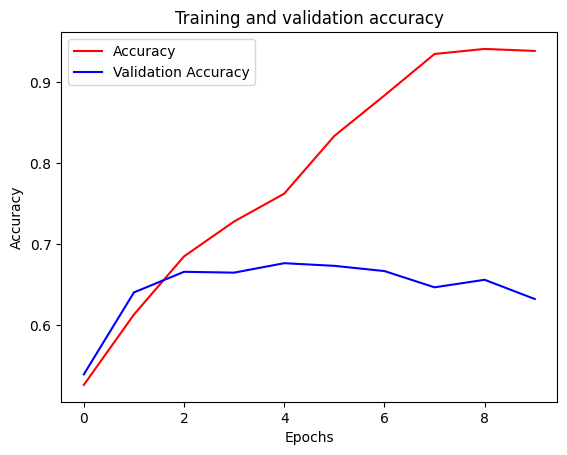

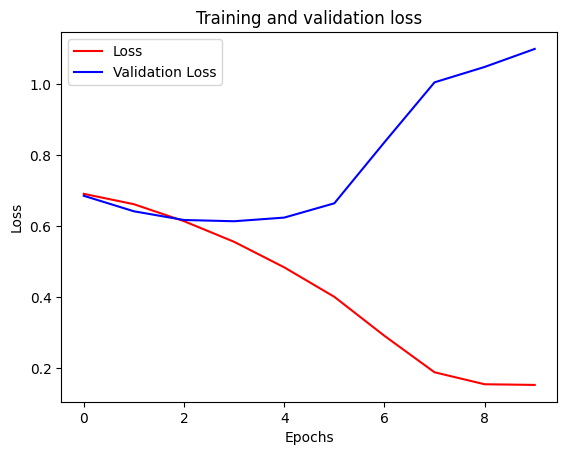

<Figure size 640x480 with 0 Axes>

In [28]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!